In [1]:
import torch
from transformers import LlamaTokenizer, LlamaForCausalLM

model_path = 'mtgv/MobileLLaMA-1.4B-Chat'

tokenizer = LlamaTokenizer.from_pretrained(model_path)
model = LlamaForCausalLM.from_pretrained(
    model_path, torch_dtype=torch.float16, device_map='auto',
)

prompt = 'Q: What is the largest animal?\nA:'
input_ids = tokenizer(prompt, return_tensors="pt").input_ids

generation_output = model.generate(
    input_ids=input_ids, max_new_tokens=32
)
print(tokenizer.decode(generation_output[0]))

comet_ml is installed but `COMET_API_KEY` is not set.
/home/shangyu/miniconda3/envs/nerf2mesh/lib/python3.9/site-packages/transformers/generation/utils.py:1535: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


<s>Q: What is the largest animal?
A: The largest animal is the blue whale, which can weigh up to 179,000 kilograms (300,0


In [3]:
from scripts.inference import inference_once

model_path = "mtgv/MobileVLM-1.7B"
image_file = "../gaussian-splatting/data/360_v2/garden/images_4/DSC07956.JPG"
prompt_str = "Can you tell me what is in the scene?"
# prompt_str = "Who is the author of this book?\nAnswer the question using a single word or phrase."
# (or) What is the title of this book?
# (or) Is this book related to Education & Teaching?

args = type('Args', (), {
    "model_path": model_path,
    "image_file": image_file,
    "prompt": prompt_str,
    "conv_mode": "v1",
    "temperature": 0, 
    "top_p": None,
    "num_beams": 1,
    "max_new_tokens": 512,
    "load_8bit": False,
    "load_4bit": False,
})()

inference_once(args)

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 32000. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
/home/shangyu/miniconda3/envs/nerf2mesh/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/shangyu/miniconda3/envs/nerf2mesh/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `None` -- this flag is onl

🚀 MobileVLM-1.7B: In the scene, there is a wooden table with a vase on top of it, surrounded by a garden setting. The table is placed in a grassy area, and there are potted plants nearby.



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.transforms import ToTensor
from PIL import Image
import io

In [2]:

def run_ours_box_or_points(img_path, pts_sampled, pts_labels, model):
    image_np = np.array(Image.open(img_path))
    img_tensor = ToTensor()(image_np).cuda().half()
    pts_sampled = torch.reshape(torch.tensor(pts_sampled), [1, 1, -1, 2]).cuda().half()
    pts_labels = torch.reshape(torch.tensor(pts_labels), [1, 1, -1]).cuda().half()
    predicted_logits, predicted_iou = model(
        img_tensor[None, ...],
        pts_sampled,
        pts_labels,
    )

    sorted_ids = torch.argsort(predicted_iou, dim=-1, descending=True)
    predicted_iou = torch.take_along_dim(predicted_iou, sorted_ids, dim=2)
    predicted_logits = torch.take_along_dim(
        predicted_logits, sorted_ids[..., None, None], dim=2
    )

    return torch.ge(predicted_logits[0, 0, 0, :, :], 0).cpu().detach().numpy()

In [3]:

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.8])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="yellow", facecolor=(0, 0, 0, 0), lw=5)
    )

def show_anns_ours(mask, ax):
    ax.set_autoscale_on(False)
    img = np.ones((mask.shape[0], mask.shape[1], 4))
    img[:, :, 3] = 0
    color_mask = [0, 1, 0, 0.7]
    img[np.logical_not(mask)] = color_mask
    ax.imshow(img)

In [4]:
from efficient_sam.build_efficient_sam import build_efficient_sam_vitt, build_efficient_sam_vits
efficient_sam_vits_model = build_efficient_sam_vits()
efficient_sam_vits_model.eval().cuda().half()

EfficientSam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (proj): Linear(in_features=384, out_features=384, bias=True)
        )
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(384, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    

In [5]:
image_path = "assets/dogs.jpg"
image_np = np.array(Image.open(image_path))
img_tensor = ToTensor()(image_np).cuda().half()
efficient_sam_vits_model.get_image_embeddings(img_tensor[None, ...]).shape

torch.Size([1, 256, 64, 64])

torch.float16
torch.float16


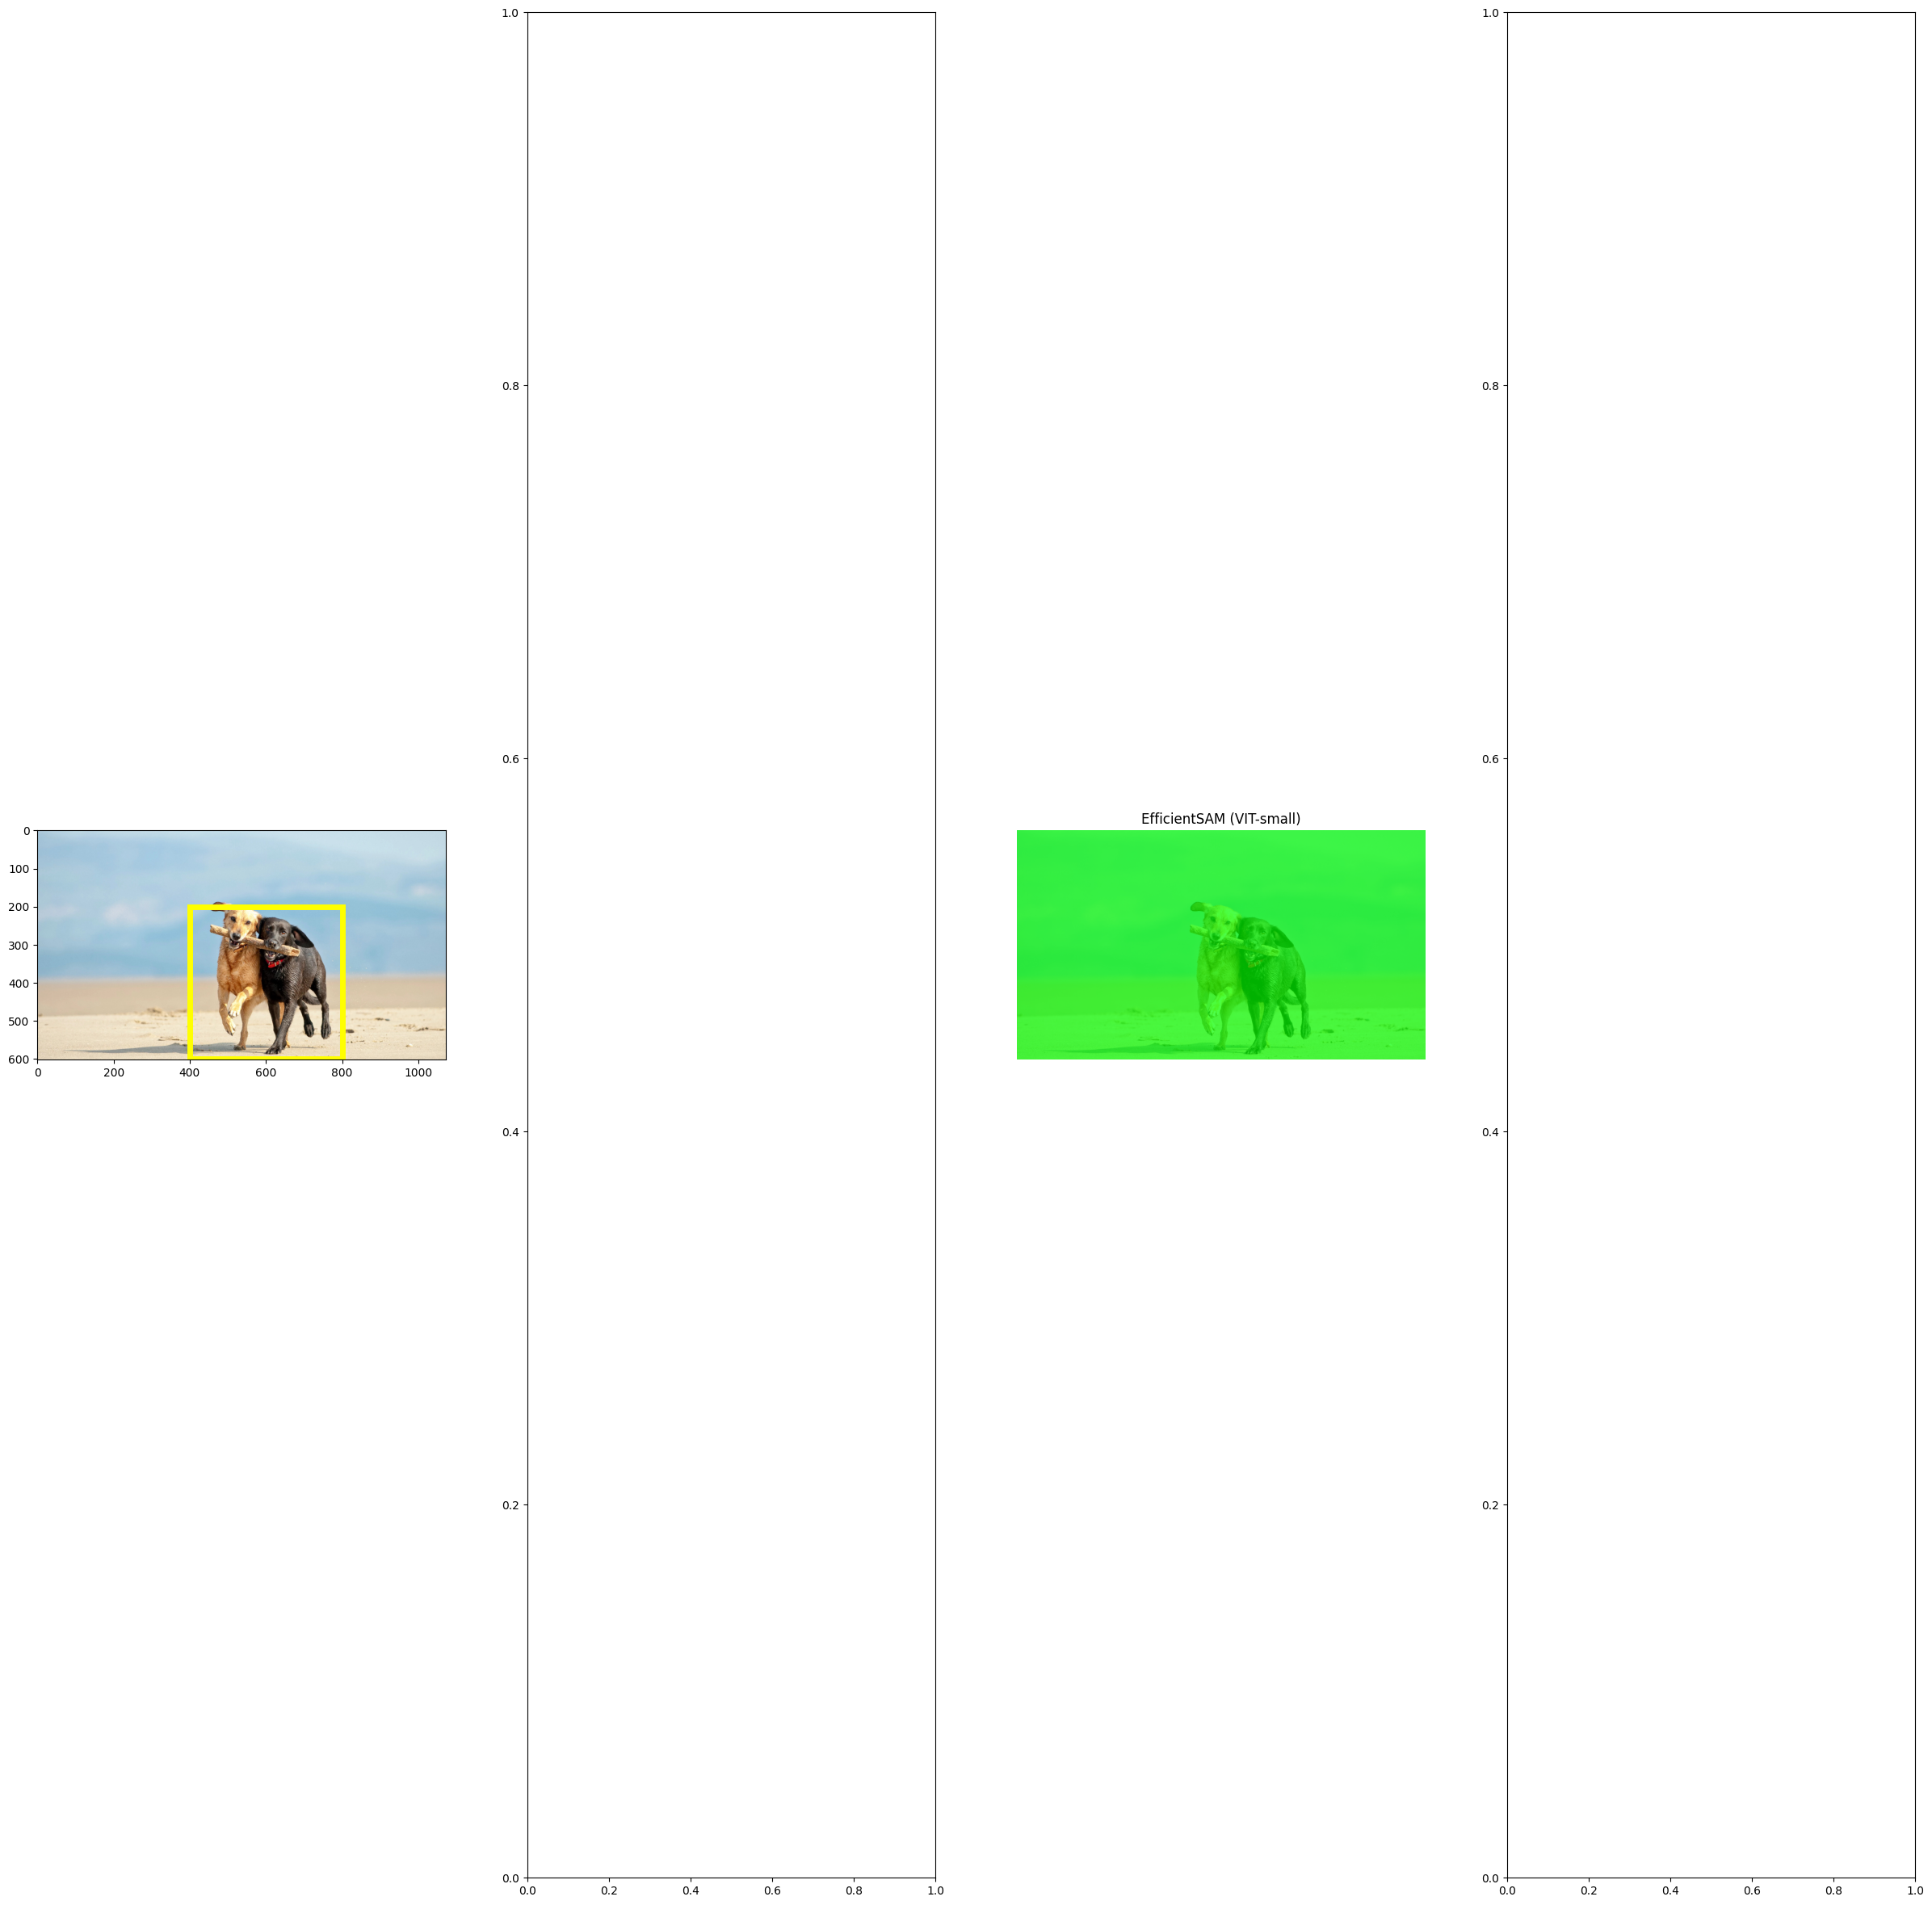

In [6]:
x1=400
y1=200
x2=800
y2=600
w=x2-x1
h=y2-y1

fig, ax = plt.subplots(1, 4, figsize=(30, 30))
input_point = np.array([[x1, y1], [x2, y2]])
input_label = np.array([2,3])

image = np.array(Image.open(image_path))
show_points(input_point, input_label, ax[0])
show_box([x1,y1,x2,y2], ax[0])
ax[0].imshow(image)


# ax[1].imshow(image)
# mask_efficient_sam_vitt = run_ours_box_or_points(image_path, input_point, input_label, efficient_sam_vitt_model)
# show_anns_ours(mask_efficient_sam_vitt, ax[1])
# ax[1].title.set_text("EfficientSAM (VIT-tiny)")
# ax[1].axis('off')

ax[2].imshow(image)
mask_efficient_sam_vits = run_ours_box_or_points(image_path, input_point, input_label, efficient_sam_vits_model)
show_anns_ours(mask_efficient_sam_vits, ax[2])
ax[2].title.set_text("EfficientSAM (VIT-small)")
ax[2].axis('off')


# ax[3].imshow(image)
# mask_squeeze_sam = run_ours_box_or_points(image_path, input_point, input_label, squeeze_sam_model)
# show_anns_ours(mask_squeeze_sam, ax[3])
# ax[3].title.set_text("SqueezeSAM")
# ax[3].axis('off')

plt.show()

RuntimeError: "compute_indices_weights_linear" not implemented for 'Half'

In [15]:
a = torch.tensor((0,))

In [16]:
a.shape

torch.Size([1])

In [13]:
a

tensor(0)

In [14]:
a.item()

0

In [2]:
import os
os.environ

environ{'CHROME_DESKTOP': 'code-url-handler.desktop',
        'CONDA_DEFAULT_ENV': '3dgs',
        'CONDA_EXE': '/home/user/anaconda3/bin/conda',
        'CONDA_PREFIX': '/home/user/anaconda3/envs/3dgs',
        'CONDA_PROMPT_MODIFIER': '(3dgs) ',
        'CONDA_PYTHON_EXE': '/home/user/anaconda3/bin/python',
        'CONDA_SHLVL': '2',
        'DBUS_SESSION_BUS_ADDRESS': 'unix:path=/run/user/1000/bus,guid=e9d3badf562bcc00555e55d465853f47',
        'DBUS_STARTER_ADDRESS': 'unix:path=/run/user/1000/bus,guid=e9d3badf562bcc00555e55d465853f47',
        'DBUS_STARTER_BUS_TYPE': 'session',
        'DEBUGINFOD_URLS': 'https://debuginfod.ubuntu.com ',
        'DESKTOP_SESSION': 'ubuntu',
        'DISPLAY': ':0',
        'GDK_BACKEND': 'x11',
        'GDMSESSION': 'ubuntu',
        'GDM_LANG': 'zh_CN',
        'GIO_LAUNCHED_DESKTOP_FILE': '/usr/share/applications/code.desktop',
        'GIO_LAUNCHED_DESKTOP_FILE_PID': '2161536',
        'GNOME_DESKTOP_SESSION_ID': 'this-is-deprecated',
        

In [1]:
import torch
from transformers import LlamaTokenizer, LlamaForCausalLM


model_path = 'TinyLlama/TinyLlama-1.1B-Chat-V1.0'

tokenizer = LlamaTokenizer.from_pretrained(model_path)
model = LlamaForCausalLM.from_pretrained(
    model_path, torch_dtype=torch.float16, device_map='auto',
)

prompt = 'Q: What is the largest animal?\nA:'
input_ids = tokenizer(prompt, return_tensors="pt").input_ids

generation_output = model.generate(
    input_ids=input_ids, max_new_tokens=32
)
print(tokenizer.decode(generation_output[0]))

/home/user/anaconda3/envs/3dgs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-01-14 21:14:50,934] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /TinyLlama/TinyLlama-1.1B-Chat-V1.0/resolve/main/tokenizer_config.json (Caused by ProxyError('Cannot connect to proxy.', NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f1ae79f7f70>: Failed to establish a new connection: [Errno 111] Connection refused')))"), '(Request ID: f30d4025-8b4a-4088-8ce6-950474c585c5)')' thrown while requesting HEAD https://huggingface.co/TinyLlama/TinyLlama-1.1B-Chat-V1.0/resolve/main/tokenizer_config.json


ProxyError: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /TinyLlama/TinyLlama-1.1B-Chat-V1.0/resolve/main/tokenizer_config.json (Caused by ProxyError('Cannot connect to proxy.', NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f1ae79f7f70>: Failed to establish a new connection: [Errno 111] Connection refused')))"), '(Request ID: f30d4025-8b4a-4088-8ce6-950474c585c5)')